In [1]:
from datetime import datetime
from operator import itemgetter
import os
import os.path
import re
from urllib.request import urlopen

import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
populations_url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'
mortalities_url = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_by_mortality_rate'
coronavirus_url = 'https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic_deaths/WHO_situation_reports'

populations_headings = ['Rank', 'Country (or dependent territory)', 'Population']
populations_country = populations_headings[1]
populations_data = populations_headings[2]
mortalities_headings = ['Country/Territory', 'OECD 2011', 'OECD 2011.1', 'CIA WF 2017', 'CIA WF 2017.1']
mortalities_country = mortalities_headings[0]
mortalities_data = mortalities_headings[3]
coronavirus_headings = ['Date', 'First reported case']
coronavirus_country = coronavirus_headings[0]
coronavirus_start_as_text = coronavirus_headings[1]
coronavirus_start = '___start'
coronavirus_days_since = '___days_since_start'

coronavirus_countries_translations = { 
      'usa' : 'united states', 
      'uk' : 'united kingdom', 
      'uae' : 'united arab emirates',
      'drc' : 'dr congo',
    }


def get_html_from_url(url):
    with urlopen(url) as page:
        html_bytes = page.read()
        html_text = html_bytes.decode('utf-8')
        return html_text
    
def get_html_tables(html, headings, last=False, all_tables=False):
    tables = pd.read_html(html, header=0)
    tables = reversed(tables) if last else tables
    selected_tables = []
    for table in tables:
        candidate_headings = table.columns.values[:len(headings)]
        if len(candidate_headings) < len(headings):
            continue
        if all(candidate_headings == headings):
            selected_tables.append(table)
            if not all_tables:
                break
    return selected_tables if all_tables else (selected_tables[0] if selected_tables else None)

In [3]:
clean1_re = re.compile(r'((\[.*\])|(\(.*\)))+')
clean2_re = re.compile(r'\s+')
clean3_re = re.compile(r'[^a-z ]+')
def clean(text, translate=None):
    clean1 = clean1_re.sub('', text).strip().lower()
    clean2 = clean2_re.sub(' ', clean1)
    clean3 = clean3_re.sub('', clean2)
    if not translate:
        return clean3
    if translate:
        return translate.get(clean3, clean3)

In [4]:
populations_html = get_html_from_url(populations_url)
populations_table = get_html_tables(populations_html, populations_headings)
populations_table[populations_country] = populations_table[populations_country].apply(clean)
populations_table

,Rank,Country (or dependent territory),Population,% of worldpopulation,Date,Source
0,1,china,1402030160,NaN,2 Apr 2020,National population clock[3]
1,2,india,1360537008,NaN,2 Apr 2020,National population clock[4]
2,3,united states,329556365,NaN,2 Apr 2020,National population clock[5]
3,4,indonesia,266911900,NaN,1 Jul 2019,National annual projection[6]
4,5,pakistan,219148520,NaN,2 Apr 2020,2017 census[7]
...,...,...,...,...,...,...
237,–,tokelau,1400,NaN,1 Jul 2018,National annual estimate[91]
238,195,vatican city,799,NaN,1 Jul 2019,UN projection[2]
239,–,cocos,538,NaN,30 Jun 2018,National estimate[196]
240,–,pitcairn islands,50,NaN,1 Jan 2019,National estimate[197]


In [5]:
mortalities_html = get_html_from_url(mortalities_url)
mortalities_table = get_html_tables(mortalities_html, mortalities_headings)
mortalities_table[mortalities_country] = mortalities_table[mortalities_country].apply(clean)
mortalities_table

,Country/Territory,OECD 2011,OECD 2011.1,CIA WF 2017,CIA WF 2017.1
0,countryterritory,Rate‰,Rank,Rate ‰,Rank
1,world,8.30,0,7.99,0
2,afghanistan,18.20,2,13.40,10
3,albania,6.90,144,6.47,152
4,algeria,4.40,207,4.31,205
...,...,...,...,...,...
234,tokelau,7.60,121,NaN,NaN
235,turks and caicos islands,2.30,232,3.08,221
236,british virgin islands,3.50,222,4.93,190
237,us virgin islands,7.40,126,8.24,91


In [6]:
coronavirus_html = get_html_from_url(coronavirus_url)
coronavirus_tables = get_html_tables(coronavirus_html, coronavirus_headings, last=True, all_tables=True)
coronavirus_table = coronavirus_tables[0]
# coronavirus_start_as_text_reverse_index = len(coronavirus_table.columns) - coronavirus_table.columns.get_loc(coronavirus_start_as_text)
coronavirus_table[coronavirus_country] = coronavirus_table[coronavirus_country].apply(lambda c: clean(c, translate=coronavirus_countries_translations))
coronavirus_last_deaths = coronavirus_table.columns.values[-1]
for i,ct in enumerate(coronavirus_tables[1:]):
    ct = ct.rename(columns={coronavirus_start_as_text : f'_{coronavirus_start_as_text}___{i}'})
    ct[coronavirus_country] = ct[coronavirus_country].apply(lambda c: clean(c, translate=coronavirus_countries_translations))
    coronavirus_table = pd.merge(left=ct, right=coronavirus_table, how='outer', left_on=coronavirus_country, right_on=coronavirus_country)
coronavirus_table

,Date,_First reported case___4,Jan 19,Jan 20,Jan 21,Jan 22,Jan 23,Jan 24,Jan 25,Jan 26,...,Mar 24,Mar 25,Mar 26,Mar 27,Mar 28,Mar 29,Mar 30,Mar 31,First reported case,Apr 1
0,world,NaN,3,6,6,6,17,23,41,56,...,16231,18433,20834,23335,26492,29957,33106,36405,NaN,40591
1,china,"January 19, 2020",3,6,6,6,17,23,41,56,...,3283,3287,3293,3298,3301,3306,3310,3314,"January 19, 2020",3321
2,references,References,References,References,[2],[3],[4],[5],[6],[7],...,[65],[66],[67],[68],[69],[70],[71],[72],References,[73]
3,notes this page summarises the deaths reporte...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,countries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,86,91,98,103,111,115,118,120,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,guernsey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"April 1, 2020",1
130,myanmar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"April 1, 2020",1
131,oman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"April 1, 2020",1
132,tanzania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"April 1, 2020",1


In [7]:
# Makes first inner join
populations_mortalities = pd.merge(left=populations_table, right=mortalities_table, 
                                   left_on=populations_country, right_on=mortalities_country)
populations_mortalities

,Rank,Country (or dependent territory),Population,% of worldpopulation,Date,Source,Country/Territory,OECD 2011,OECD 2011.1,CIA WF 2017,CIA WF 2017.1
0,1,china,1402030160,NaN,2 Apr 2020,National population clock[3],china,7.10,135,7.44,115
1,2,india,1360537008,NaN,2 Apr 2020,National population clock[4],india,7.10,133,7.35,118
2,3,united states,329556365,NaN,2 Apr 2020,National population clock[5],united states,8.10,104,8.15,94
3,4,indonesia,266911900,NaN,1 Jul 2019,National annual projection[6],indonesia,6.30,159,6.34,156
4,5,pakistan,219148520,NaN,2 Apr 2020,2017 census[7],pakistan,7.30,128,6.58,146
...,...,...,...,...,...,...,...,...,...,...,...
223,–,montserrat,4989,NaN,1 Jul 2019,UN projection[2],montserrat,11.20,38,6.52,150
224,–,niue,1520,NaN,1 Jul 2018,National annual estimate[91],niue,9.70,56,NaN,NaN
225,–,tokelau,1400,NaN,1 Jul 2018,National annual estimate[91],tokelau,7.60,121,NaN,NaN
226,–,pitcairn islands,50,NaN,1 Jan 2019,National estimate[197],pitcairn islands,12.30,31,NaN,NaN


In [8]:
# Makes second inner join
populations_mortalities_coronavirus = pd.merge(left=populations_mortalities, right=coronavirus_table, 
                                               left_on=populations_country, right_on=coronavirus_country)
populations_mortalities_coronavirus

,Rank,Country (or dependent territory),Population,% of worldpopulation,Date_x,Source,Country/Territory,OECD 2011,OECD 2011.1,CIA WF 2017,...,Mar 24,Mar 25,Mar 26,Mar 27,Mar 28,Mar 29,Mar 30,Mar 31,First reported case,Apr 1
0,1,china,1402030160,NaN,2 Apr 2020,National population clock[3],china,7.10,135,7.44,...,3283,3287,3293,3298,3301,3306,3310,3314,"January 19, 2020",3321
1,2,india,1360537008,NaN,2 Apr 2020,National population clock[4],india,7.10,133,7.35,...,9,9,13,17,17,25,29,29,"March 13, 2020",38
2,3,united states,329556365,NaN,2 Apr 2020,National population clock[5],united states,8.10,104,8.15,...,471,673,884,991,1243,1668,2112,2398,"March 3, 2020",2850
3,4,indonesia,266911900,NaN,1 Jul 2019,National annual projection[6],indonesia,6.30,159,6.34,...,49,55,58,78,87,102,114,122,"March 11, 2020",136
4,5,pakistan,219148520,NaN,2 Apr 2020,2017 census[7],pakistan,7.30,128,6.58,...,6,7,8,8,9,13,18,25,"March 20, 2020",26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,–,cayman islands,65813,NaN,31 Dec 2018,National estimate[179],cayman islands,3.20,227,5.41,...,1,1,1,1,1,1,1,1,"March 16, 2020",1
117,–,guernsey,62792,NaN,31 Mar 2019,National estimate[181],guernsey,8.40,92,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"April 1, 2020",1
118,–,saint martin,35746,NaN,1 Jan 2016,National estimate[189],saint martin,3.90,219,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,"March 31, 2020",2
119,191,san marino,33574,NaN,31 Dec 2019,National monthly estimate[190],san marino,6.90,145,8.70,...,20,21,21,21,21,22,24,25,"March 8, 2020",26


In [9]:
def get_start_date(date_as_text):
    try:
        # Date format: "March 05, 2020"
        return datetime.strptime(date_as_text, '%B %d, %Y')
    except (ValueError, TypeError):
        return np.nan

populations_mortalities_coronavirus[coronavirus_start] = populations_mortalities_coronavirus.apply(lambda row: get_start_date(row[coronavirus_start_as_text]), axis=1)
populations_mortalities_coronavirus[coronavirus_start]

0     2020-01-19
1     2020-03-13
2     2020-03-03
3     2020-03-11
4     2020-03-20
         ...    
116   2020-03-16
117   2020-04-01
118   2020-03-31
119   2020-03-08
120          NaT
Name: ___start, Length: 121, dtype: datetime64[ns]

In [10]:
def days_since_start(start_date, reference_date=datetime.now()):
    days_since = (reference_date-start_date).days
    return days_since if days_since>0 else np.nan

# populations_mortalities_coronavirus[coronavirus_start] = populations_mortalities_coronavirus[coronavirus_start].apply(days_since_start)
populations_mortalities_coronavirus[coronavirus_days_since] = populations_mortalities_coronavirus.apply(lambda row: days_since_start(row[coronavirus_start]), axis=1)
populations_mortalities_coronavirus[coronavirus_days_since]

0      74.0
1      20.0
2      30.0
3      22.0
4      13.0
       ... 
116    17.0
117     1.0
118     2.0
119    25.0
120     NaN
Name: ___days_since_start, Length: 121, dtype: float64

In [11]:
populations_mortalities_coronavirus = populations_mortalities_coronavirus.dropna(subset=[populations_country, populations_data, mortalities_data, coronavirus_days_since])
populations_mortalities_coronavirus

,Rank,Country (or dependent territory),Population,% of worldpopulation,Date_x,Source,Country/Territory,OECD 2011,OECD 2011.1,CIA WF 2017,...,Mar 26,Mar 27,Mar 28,Mar 29,Mar 30,Mar 31,First reported case,Apr 1,___start,___days_since_start
0,1,china,1402030160,NaN,2 Apr 2020,National population clock[3],china,7.10,135,7.44,...,3293,3298,3301,3306,3310,3314,"January 19, 2020",3321,2020-01-19,74.0
1,2,india,1360537008,NaN,2 Apr 2020,National population clock[4],india,7.10,133,7.35,...,13,17,17,25,29,29,"March 13, 2020",38,2020-03-13,20.0
2,3,united states,329556365,NaN,2 Apr 2020,National population clock[5],united states,8.10,104,8.15,...,884,991,1243,1668,2112,2398,"March 3, 2020",2850,2020-03-03,30.0
3,4,indonesia,266911900,NaN,1 Jul 2019,National annual projection[6],indonesia,6.30,159,6.34,...,58,78,87,102,114,122,"March 11, 2020",136,2020-03-11,22.0
4,5,pakistan,219148520,NaN,2 Apr 2020,2017 census[7],pakistan,7.30,128,6.58,...,8,8,9,13,18,25,"March 20, 2020",26,2020-03-20,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,–,jersey,106800,NaN,31 Dec 2018,National estimate[172],jersey,8.20,98,7.63,...,NaN,1,1,1,2,2,"March 27, 2020",2,2020-03-27,6.0
115,185,andorra,77543,NaN,31 Dec 2019,National estimate[178],andorra,3.50,221,6.82,...,3,3,3,4,6,8,"March 24, 2020",12,2020-03-24,9.0
116,–,cayman islands,65813,NaN,31 Dec 2018,National estimate[179],cayman islands,3.20,227,5.41,...,1,1,1,1,1,1,"March 16, 2020",1,2020-03-16,17.0
117,–,guernsey,62792,NaN,31 Mar 2019,National estimate[181],guernsey,8.40,92,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,"April 1, 2020",1,2020-04-01,1.0


In [20]:
countries   = np.array(populations_mortalities_coronavirus[populations_country])
populations = np.array(populations_mortalities_coronavirus[populations_data], dtype=np.float)
mortalities = np.array(populations_mortalities_coronavirus[mortalities_data], dtype=np.float)
deaths      = np.array(populations_mortalities_coronavirus[coronavirus_last_deaths], dtype=np.float)
days_since  = np.array(populations_mortalities_coronavirus[coronavirus_days_since], dtype=np.float)
min_mortalities = np.nanmin(mortalities)
max_mortalities = np.nanmax(mortalities)
max_deaths = np.nanmax(deaths)
max_days_since = np.nanmax(days_since)
countries, populations, mortalities, deaths, days_since, min_mortalities, max_mortalities, max_deaths, max_days_since

(array(['china', 'india', 'united states', 'indonesia', 'pakistan',
        'brazil', 'nigeria', 'bangladesh', 'russia', 'mexico', 'japan',
        'philippines', 'egypt', 'dr congo', 'iran', 'turkey', 'germany',
        'france', 'thailand', 'united kingdom', 'italy', 'south africa',
        'tanzania', 'myanmar', 'south korea', 'colombia', 'kenya', 'spain',
        'argentina', 'algeria', 'sudan', 'ukraine', 'iraq', 'poland',
        'canada', 'morocco', 'saudi arabia', 'uzbekistan', 'malaysia',
        'afghanistan', 'venezuela', 'peru', 'angola', 'ghana', 'cameroon',
        'australia', 'niger', 'sri lanka', 'burkina faso', 'romania',
        'chile', 'kazakhstan', 'syria', 'ecuador', 'netherlands',
        'guatemala', 'zimbabwe', 'tunisia', 'belgium', 'bolivia', 'cuba',
        'greece', 'jordan', 'dominican republic', 'sweden', 'portugal',
        'azerbaijan', 'united arab emirates', 'hungary', 'israel',
        'honduras', 'austria', 'switzerland', 'togo', 'paraguay',
       

In [13]:
# TODO : Build time-lapse matrix of death data using column names of populations_mortalities_coronavirus 
# => detect which columns are in format Month day => Mar 01
month_and_day_re = re.compile('[A-Z][a-z][a-z]\s[0-9][0-9]?')
space_replace = re.compile('\s+')
current_year = datetime.now().year
all_dates = [ (name, datetime.strptime(f'{space_replace.sub(" ", name)} {current_year}', '%b %d %Y')) for name in populations_mortalities_coronavirus.columns.values if month_and_day_re.fullmatch(name) ]
all_dates = sorted(all_dates, key=itemgetter(1))
all_dates

[('Jan\xa019', datetime.datetime(2020, 1, 19, 0, 0)),
 ('Jan\xa020', datetime.datetime(2020, 1, 20, 0, 0)),
 ('Jan\xa021', datetime.datetime(2020, 1, 21, 0, 0)),
 ('Jan\xa022', datetime.datetime(2020, 1, 22, 0, 0)),
 ('Jan\xa023', datetime.datetime(2020, 1, 23, 0, 0)),
 ('Jan\xa024', datetime.datetime(2020, 1, 24, 0, 0)),
 ('Jan\xa025', datetime.datetime(2020, 1, 25, 0, 0)),
 ('Jan\xa026', datetime.datetime(2020, 1, 26, 0, 0)),
 ('Jan\xa027', datetime.datetime(2020, 1, 27, 0, 0)),
 ('Jan\xa028', datetime.datetime(2020, 1, 28, 0, 0)),
 ('Jan\xa029', datetime.datetime(2020, 1, 29, 0, 0)),
 ('Jan\xa030', datetime.datetime(2020, 1, 30, 0, 0)),
 ('Jan\xa031', datetime.datetime(2020, 1, 31, 0, 0)),
 ('Feb\xa01', datetime.datetime(2020, 2, 1, 0, 0)),
 ('Feb\xa02', datetime.datetime(2020, 2, 2, 0, 0)),
 ('Feb\xa03', datetime.datetime(2020, 2, 3, 0, 0)),
 ('Feb\xa04', datetime.datetime(2020, 2, 4, 0, 0)),
 ('Feb\xa05', datetime.datetime(2020, 2, 5, 0, 0)),
 ('Feb\xa06', datetime.datetime(2020, 

In [14]:
all_analyses = []
for d in all_dates:
    this_deaths_field = d[0]
    this_deaths_date = d[1]
    this_deaths = np.array(populations_mortalities_coronavirus[this_deaths_field], dtype=np.float)
    this_days_since = np.array(populations_mortalities_coronavirus.apply(lambda row: days_since_start(row[coronavirus_start], reference_date=this_deaths_date), axis=1), dtype=np.float)
    this_expected_deaths = populations * mortalities * this_days_since / (1000.*365.)
    this_surplus_deaths = this_deaths/this_expected_deaths
    this_coronavirus_rate = this_deaths / (populations * this_days_since) * (1000.*365.)
    this_surplus_rate = this_coronavirus_rate/mortalities
#     assert sum(this_surplus_deaths-this_surplus_rate) < small number # The two analyses should be equal
    all_analyses.append((d[1], this_days_since, this_surplus_deaths, this_surplus_rate, this_deaths,))
all_analyses

[(datetime.datetime(2020, 1, 19, 0, 0),
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan]),
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [15]:
def filter_nans(all_arrays):
    all_nans = (~np.isnan(np.stack(all_arrays, axis=1))).all(axis=1)
    return [ a[all_nans] for a in all_arrays ] + [ all_nans ]

In [21]:
fig_size = (12, 10)
fig_dpi = 200
notice = 'github.com/dreavjr/coronavirus-deaths'
caption = 'The impact of deaths due to COVID-19 on affected countries‘ mortality rates.'
subcaption = f'Graph by Eduardo Valle, 2020 — {notice}. Country populations from several sources.\nMortality rates from CIA World Factbook 2017 estimates. COVID-19 deaths and date of first official case from WHO situation\nreports. All data apud en.wikipedia.org.'
bubble_area_factor = 16.0

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(
            n=cmap.name, a=minval, b=maxval), cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('plasma')
cmap_truncated = truncate_colormap(cmap, maxval=0.9)

legend_deaths_sizes = 10**np.arange(1, np.floor(np.log10(max_deaths))+1)
legend_deaths_elements = []
for lds in legend_deaths_sizes:
    legend_deaths_elements.append(
        Line2D([0], [0], marker='o', color='white', label=f'{int(lds)}', 
               markerfacecolor='black', alpha=0.33, markersize=np.sqrt(lds)) #*bubble_area_factor)
        )
    
mortalities_norm = colors.Normalize(vmin=min_mortalities, vmax=max_mortalities, clip=False)

def plot_frame(frame, first_appearance=None, save_figure=None):
#     all_analyses.append((d[1], this_days_since, this_surplus_deaths, this_surplus_rate, this_deaths,))

    date_f = frame[0]
    days_since_f = frame[1]
    surplus_deaths_f = frame[2]
    surplus_rate_f = frame[3]
    deaths_f = frame[4]
    
    days_since_f, surplus_deaths_f, surplus_rate_f, deaths_f, selection_f = \
            filter_nans([days_since_f, surplus_deaths_f, surplus_rate_f, deaths_f])
    
    countries_f = countries[selection_f]
    mortalities_f = mortalities[selection_f]
    
    assert (surplus_deaths_f-surplus_rate_f).sum() < 1e-9

    bubble_area_f = deaths_f # It's not necessary to sqrt the dimensions, scatter takes areas
    surplus_rate_perc_f = surplus_deaths_f*100.
    outlier_suffixes_f = np.where(surplus_rate_perc_f>100., np.char.add(np.char.add(' (', np.round(surplus_rate_perc_f).astype(np.int).astype(np.str)),')'), '')
    countries_with_suffixes_f = np.char.add(countries_f.astype(np.str), outlier_suffixes_f)
    surplus_rate_perc_clamped_f = np.minimum(surplus_rate_perc_f, 105.)

    with plt.style.context('fivethirtyeight'): 
        fig = plt.figure(figsize=fig_size, dpi=fig_dpi)
        fig.patch.set_facecolor('white')
        ax = plt.gca()
# For reference:
#         def even_ceiling(n):
#             '''Round number to first greater even integer.'''
#             return np.ceil(n / 2.) * 2
        def odd_ceiling(n):
            '''Round number to first greater odd integer.'''
            return np.ceil(n) // 2 * 2 + 1
        def odd_multiple_ceiling(n, k):
            '''Round number to first greater odd multiple of k.'''
            return odd_ceiling(n/k)*k
        ax.set_xlim(-5, odd_multiple_ceiling(max_days_since, 5))
        ax.set_ylim(-10, 110)
# For reference:
#         ax.spines['left'].set_position(('data', 0))
#         ax.spines['bottom'].set_position(('data', 0))
        for s in ax.spines:
            ax.spines[s].set_visible(False)
        ax.set_facecolor('white')
        sc = plt.scatter(days_since_f, surplus_rate_perc_clamped_f, s=bubble_area_f, c=mortalities_f, cmap=cmap_truncated, norm=mortalities_norm, alpha=0.75, clip_on=False)
        for c,cs,d,s,de in zip(countries_f, countries_with_suffixes_f, days_since_f, surplus_rate_perc_clamped_f, deaths_f):
            if first_appearance is not None and d>0. and s>0. and de>0. and c not in first_appearance:
                ax.annotate(cs, (d, s), color='red')
                first_appearance.add(c)
                continue
            if s>10 or de>1000:
                ax.annotate(cs, (d, s))
#                 print(c, d, s, de)

        ax.set_xlabel('days since first official case')
        ax.set_ylabel('coronavirus deaths / expected baseline mortality (%)')
        cbar = plt.colorbar()
        cbar.ax.set_ylabel('baseline mortality rate (‰ per annum)')
        
        ax.legend(handles=legend_deaths_elements, loc="upper right", title="COVID-19 deaths")
        
#         if selection_f.any():
#             plt.legend(*sc.legend_elements("sizes", num=6, func=lambda x: (x/bubble_area_factor)**2), title='COVID-19 deaths')


        if save_figure is None:            
            plt.figtext(0.0, 0.0, date_f.strftime('%b %d %Y'), horizontalalignment='left', fontsize=12)
            plt.figtext(0.0, -0.05, caption, wrap=True, horizontalalignment='left', fontsize=14)
            plt.figtext(0.0, -0.12, subcaption, wrap=True, horizontalalignment='left', fontsize=12)
        else:
            plt.figtext(0.02, 0.02, date_f.strftime('%b %d %Y'), horizontalalignment='left', fontsize=14)
            plt.figtext(0.98, 0.02, notice,                      horizontalalignment='right', fontsize=14)
            plt.savefig(save_figure, dpi='figure')
        


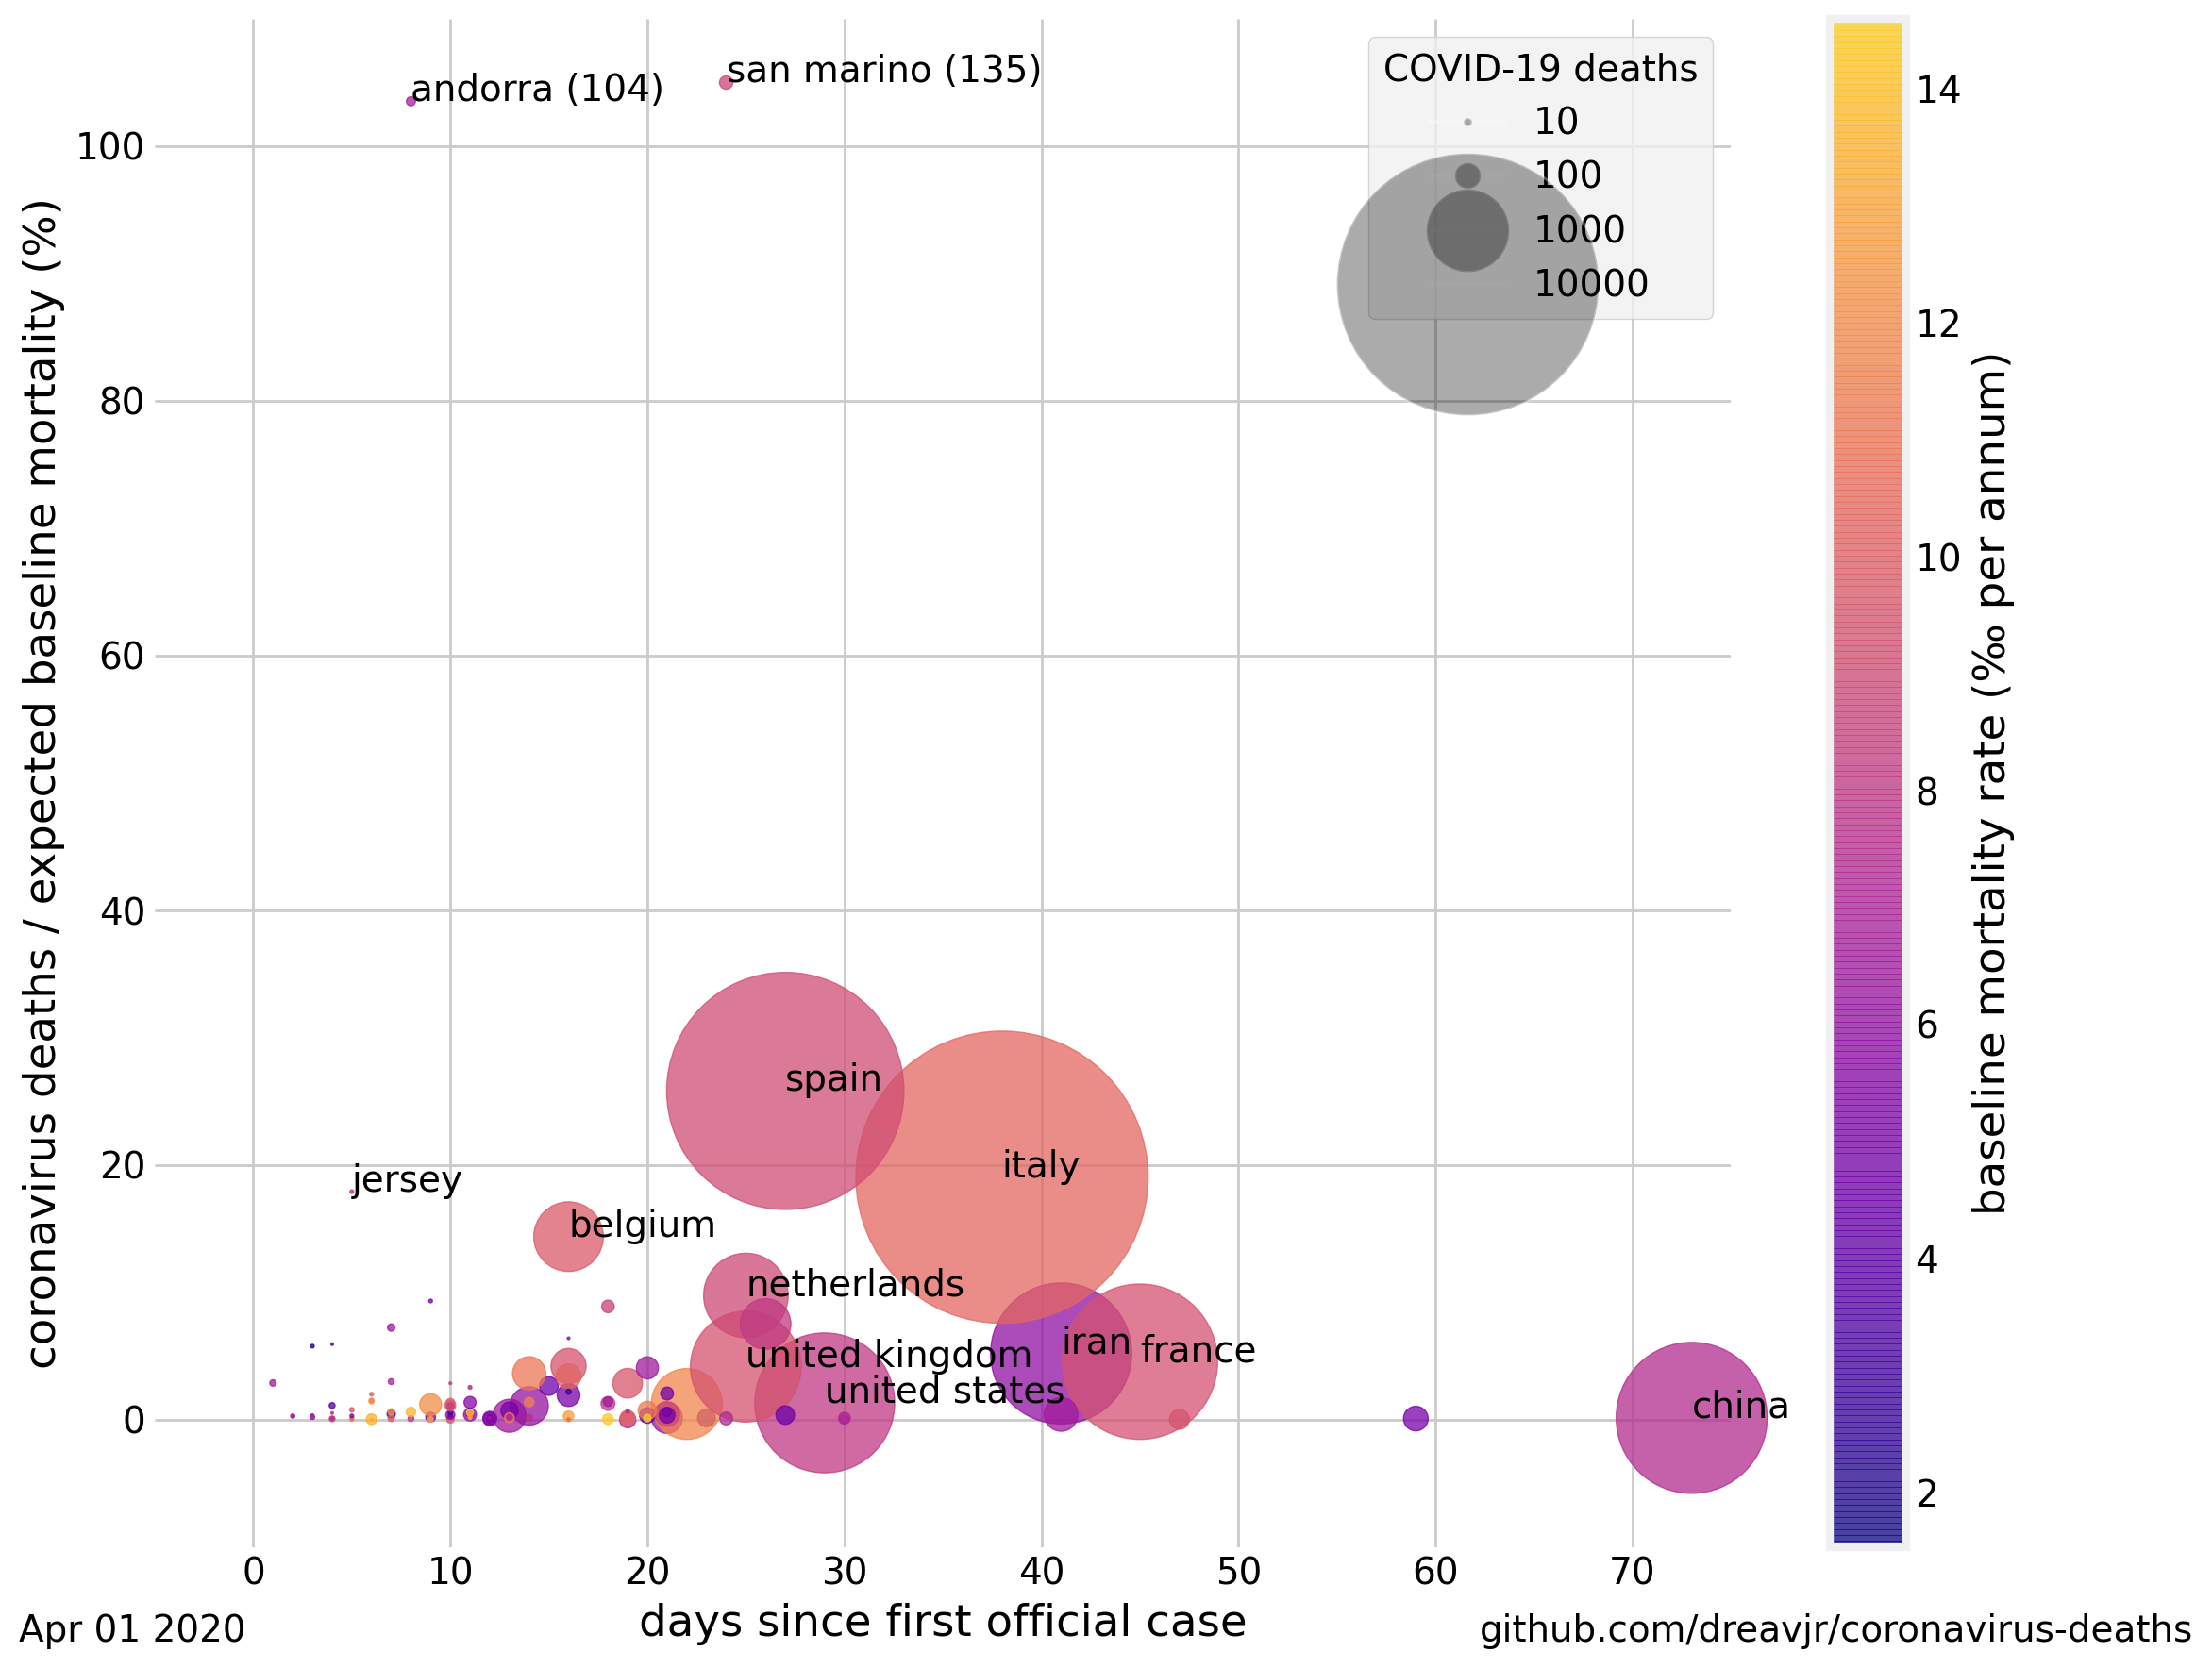

In [22]:
#     all_analyses.append((d[1], this_days_since, this_surplus_deaths, this_surplus_rate, this_deaths,))
plot_frame(all_analyses[-1], save_figure='temp.png')

In [23]:
len(all_analyses)

74

In [24]:
%%capture

animation_tail_size = 10

output_folder = 'plot_output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
# This may take a long time
first_appearance = set()

for i,frame in enumerate(all_analyses + all_analyses[-1:]*animation_tail_size):
    plot_frame(frame, first_appearance, save_figure=os.path.join(output_folder, f'frame_{i:03}.png'))